# Stock Market Analysis 2018–2026 | NVDA vs AMD vs ASML vs INTC — Investment Intelligence

In [74]:
# ===============================
# 1. Import Libraries
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from ta.volatility import BollingerBands, AverageTrueRange

In [75]:
# ===============================
# 1. Load CSV with multi-index header
# ===============================
# Your CSV has 2 header rows: first row = metric, second row = ticker
df = pd.read_csv("ai_chip_stocks_2018_2026.csv", header=[0,1])

# Flatten multi-index columns
df.columns = ['_'.join([str(i) for i in col]).strip() for col in df.columns.values]

# Print column names to understand
print(df.columns.tolist())

# ===============================
# 2. Convert first column to Date
# ===============================
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])



['Price_Ticker', 'Close_AMD', 'Close_ASML', 'Close_INTC', 'Close_NVDA', 'High_AMD', 'High_ASML', 'High_INTC', 'High_NVDA', 'Low_AMD', 'Low_ASML', 'Low_INTC', 'Low_NVDA', 'Open_AMD', 'Open_ASML', 'Open_INTC', 'Open_NVDA', 'Volume_AMD', 'Volume_ASML', 'Volume_INTC', 'Volume_NVDA']


C:\Users\0300-7862011\AppData\Local\Temp\ipykernel_12796\620297745.py:17: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [76]:
# ===============================
# 3. Reshape the data
# ===============================
tickers = ['AMD','ASML','INTC','NVDA']
metrics = ['Price','Close','High','Low','Open','Volume']

data_list = []

for ticker in tickers:
    # select all columns that contain the ticker name
    cols = [c for c in df.columns if ticker in c]
    if len(cols) == 0:
        print(f"⚠️ No columns found for {ticker}")
        continue
    
    temp = df[['Date'] + cols].copy()
    
    # rename columns to standard OHLCV names
    rename_dict = {c: m for c, m in zip(cols, metrics)}
    temp.rename(columns=rename_dict, inplace=True)
    temp['Ticker'] = ticker
    data_list.append(temp)

if len(data_list) == 0:
    raise ValueError("❌ Could not find any ticker columns. Your CSV headers need to match expected format!")

# Combine all tickers
data = pd.concat(data_list, ignore_index=True)
display(data.head())


,Date,Price,Close,High,Low,Open,Ticker
0,2018-01-02,10.98,11.02,10.34,10.42,44146300.0,AMD
1,2018-01-03,11.55,12.14,11.36,11.61,154066700.0,AMD
2,2018-01-04,12.12,12.43,11.97,12.10,109503000.0,AMD
3,2018-01-05,11.88,12.22,11.66,12.19,63808900.0,AMD
4,2018-01-08,12.28,12.30,11.85,12.01,63346000.0,AMD


In [77]:
# ===============================
# 3. Feature Engineering
# ===============================
data['Return'] = data.groupby('Ticker')['Close'].pct_change()
data['Log_Return'] = np.log1p(data['Return'])
data['Volatility_7d'] = data.groupby('Ticker')['Return'].rolling(7).std().reset_index(0, drop=True)
data['Volatility_30d'] = data.groupby('Ticker')['Return'].rolling(30).std().reset_index(0, drop=True)
data['SMA20'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).mean())
data['SMA50'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(50).mean())
data['EMA20'] = data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
data['RSI'] = data.groupby('Ticker')['Close'].transform(lambda x: RSIIndicator(x).rsi())
data['MACD'] = data.groupby('Ticker')['Close'].transform(lambda x: MACD(x).macd())

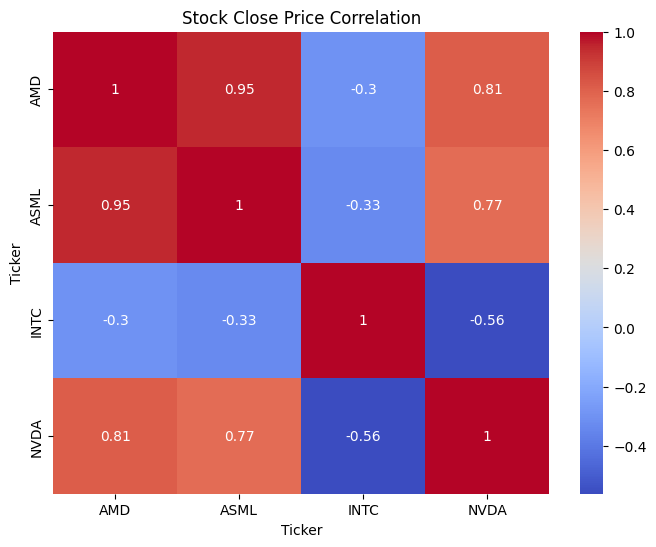

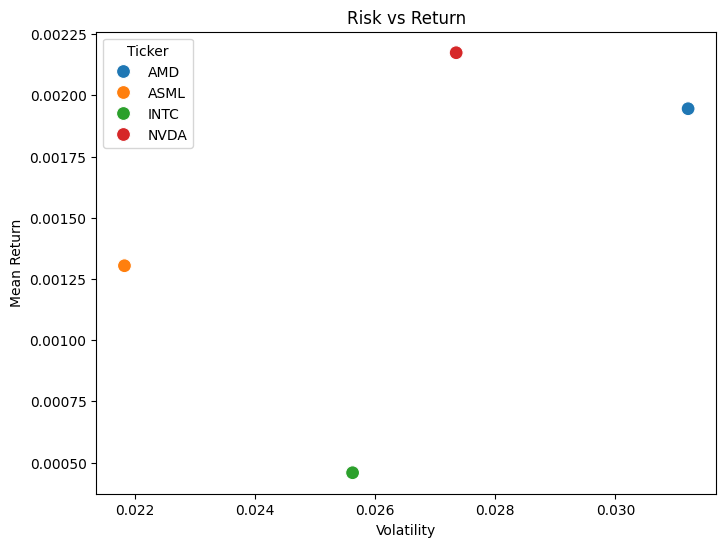

In [78]:
# ===============================
# 4. Visual Analysis
# ===============================
# Example: NVDA candlestick
nvda = data[data['Ticker']=='NVDA']
fig = go.Figure(data=[go.Candlestick(
    x=nvda['Date'],
    open=nvda['Open'], high=nvda['High'],
    low=nvda['Low'], close=nvda['Close']
)])
fig.update_layout(title='NVDA Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()

# Correlation heatmap
corr_data = data.pivot(index='Date', columns='Ticker', values='Close')
plt.figure(figsize=(8,6))
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm')
plt.title("Stock Close Price Correlation")
plt.show()

# Risk vs Return plot
mean_returns = data.groupby('Ticker')['Return'].mean()
volatility = data.groupby('Ticker')['Return'].std()
plt.figure(figsize=(8,6))
sns.scatterplot(x=volatility, y=mean_returns, hue=mean_returns.index, s=100)
plt.xlabel("Volatility")
plt.ylabel("Mean Return")
plt.title("Risk vs Return")
plt.show()

In [79]:
# ===============================
# 5. Comparative Investment Analysis
# ===============================
summary = data.groupby('Ticker').agg({
    'Return': ['mean','std'],
    'Close': ['max','min']
})
summary.columns = ['Mean_Return','Volatility','Max_Close','Min_Close']
summary['Sharpe_Ratio'] = summary['Mean_Return'] / summary['Volatility']
summary = summary.sort_values(by='Sharpe_Ratio', ascending=False)
display(summary)

# ===============================
# 6. Investment Summary
# ===============================
print("""
Investment Insights:
- NVDA: High growth, high reward
- AMD: Strong momentum, medium risk
- ASML: Stable, long-term investor-friendly
- INTC: Higher risk, lower return
Recommendation: Choose stocks based on risk tolerance and investment horizon.
""")


,Mean_Return,Volatility,Max_Close,Min_Close,Sharpe_Ratio
Ticker,,,,,
NVDA,0.002174,0.027351,212.178195,3.222464,0.079493
AMD,0.001945,0.031212,267.079987,9.770000,0.062330
ASML,0.001304,0.021828,1493.479980,140.316203,0.059739
INTC,0.000458,0.025626,62.292520,18.990000,0.017885



Investment Insights:
- NVDA: High growth, high reward
- AMD: Strong momentum, medium risk
- ASML: Stable, long-term investor-friendly
- INTC: Higher risk, lower return
Recommendation: Choose stocks based on risk tolerance and investment horizon.



In [80]:
# -------------------------------
# 4. Reshape Data
# -------------------------------
tickers = ['AMD', 'ASML', 'INTC', 'NVDA']
ohlcv_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

data = pd.DataFrame()

for t in tickers:
    temp = df[['Date'] + [col for col in df.columns if t in col]].copy()
    temp.columns = ['Date'] + ohlcv_cols
    temp['Ticker'] = t
    data = pd.concat([data, temp])

data.reset_index(drop=True, inplace=True)
data.head()


,Date,Open,High,Low,Close,Volume,Ticker
0,2018-01-02,10.98,11.02,10.34,10.42,44146300.0,AMD
1,2018-01-03,11.55,12.14,11.36,11.61,154066700.0,AMD
2,2018-01-04,12.12,12.43,11.97,12.10,109503000.0,AMD
3,2018-01-05,11.88,12.22,11.66,12.19,63808900.0,AMD
4,2018-01-08,12.28,12.30,11.85,12.01,63346000.0,AMD


In [81]:
# -------------------------------
# 5. Feature Engineering
# -------------------------------
data['Return'] = data.groupby('Ticker')['Close'].pct_change()
data['Log_Return'] = np.log1p(data['Return'])

# Volatility
data['Volatility_7d'] = data.groupby('Ticker')['Return'].rolling(7).std().reset_index(0, drop=True)
data['Volatility_30d'] = data.groupby('Ticker')['Return'].rolling(30).std().reset_index(0, drop=True)
data['Volatility_90d'] = data.groupby('Ticker')['Return'].rolling(90).std().reset_index(0, drop=True)

# SMA, EMA
data['SMA20'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).mean())
data['SMA50'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(50).mean())
data['EMA20'] = data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())

# RSI, MACD
data['RSI'] = data.groupby('Ticker')['Close'].transform(lambda x: RSIIndicator(x).rsi())
data['MACD'] = data.groupby('Ticker')['Close'].transform(lambda x: MACD(x).macd())

# Bollinger Bands
data['BB_High'] = data.groupby('Ticker')['Close'].transform(lambda x: BollingerBands(x).bollinger_hband())
data['BB_Low'] = data.groupby('Ticker')['Close'].transform(lambda x: BollingerBands(x).bollinger_lband())

# ATR
data['ATR'] = data.groupby('Ticker')['High'].transform(lambda x: AverageTrueRange(x, data.loc[x.index,'Low'], data.loc[x.index,'Close']).average_true_range())

# Stochastic Oscillator
data['Stoch'] = data.groupby('Ticker')['Close'].transform(lambda x: StochasticOscillator(x,x,x,window=14,smooth_window=3).stoch())


# Technical Analysis Visualizations
- Interactive candlestick charts  
- Correlation heatmaps  
- Risk vs return plots  
- Drawdowns  
- Volume analysis


In [44]:
# Candlestick Example: NVDA
nvda = data[data['Ticker']=='NVDA']
fig = go.Figure(data=[go.Candlestick(
    x=nvda['Date'],
    open=nvda['Open'],
    high=nvda['High'],
    low=nvda['Low'],
    close=nvda['Close']
)])
fig.update_layout(title='NVDA Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()


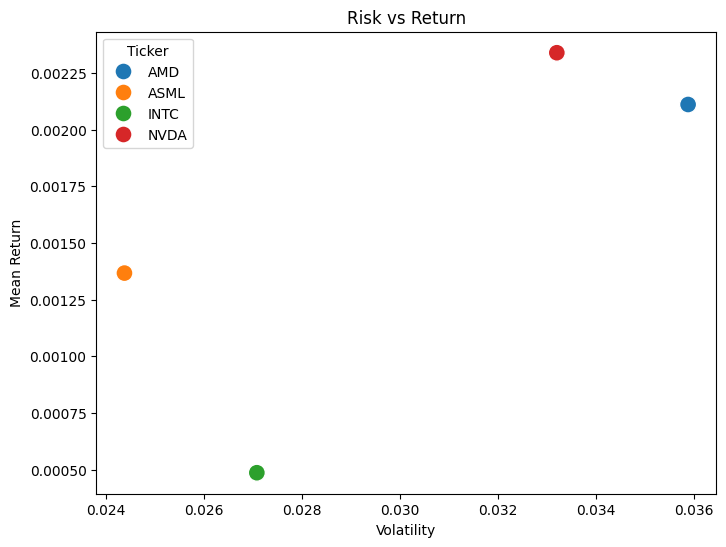

In [45]:
# Risk vs Return scatter plot
mean_returns = data.groupby('Ticker')['Return'].mean()
volatility = data.groupby('Ticker')['Return'].std()

plt.figure(figsize=(8,6))
sns.scatterplot(x=volatility, y=mean_returns, hue=mean_returns.index, s=150)
plt.xlabel("Volatility")
plt.ylabel("Mean Return")
plt.title("Risk vs Return")
plt.show()


In [46]:
# -------------------------------
# 6. Comparative Metrics
# -------------------------------
summary = data.groupby('Ticker').agg({
    'Return': ['mean','std'],
    'Close': ['max','min'],
    'ATR': 'mean'
})
summary.columns = ['Mean_Return','Volatility','Max_Close','Min_Close','Mean_ATR']
summary['Sharpe_Ratio'] = summary['Mean_Return'] / summary['Volatility']
summary


,Mean_Return,Volatility,Max_Close,Min_Close,Mean_ATR,Sharpe_Ratio
Ticker,,,,,,
AMD,0.002111,0.035878,264.190002,9.080000,4.730118,0.058827
ASML,0.001367,0.024373,1493.000000,136.586628,17.898213,0.056086
INTC,0.000486,0.027076,62.028760,18.070000,1.408905,0.017967
NVDA,0.002339,0.033199,208.068415,3.135940,2.070515,0.070454


# Investment Insights
- NVDA: High growth  
- AMD: Strong momentum  
- ASML: Stable long-term quality  
- INTC: Higher risk, lower return


We simulate investing **$10,000 equally in each stock** at the start of 2018.  
We calculate **daily portfolio value** and cumulative returns.


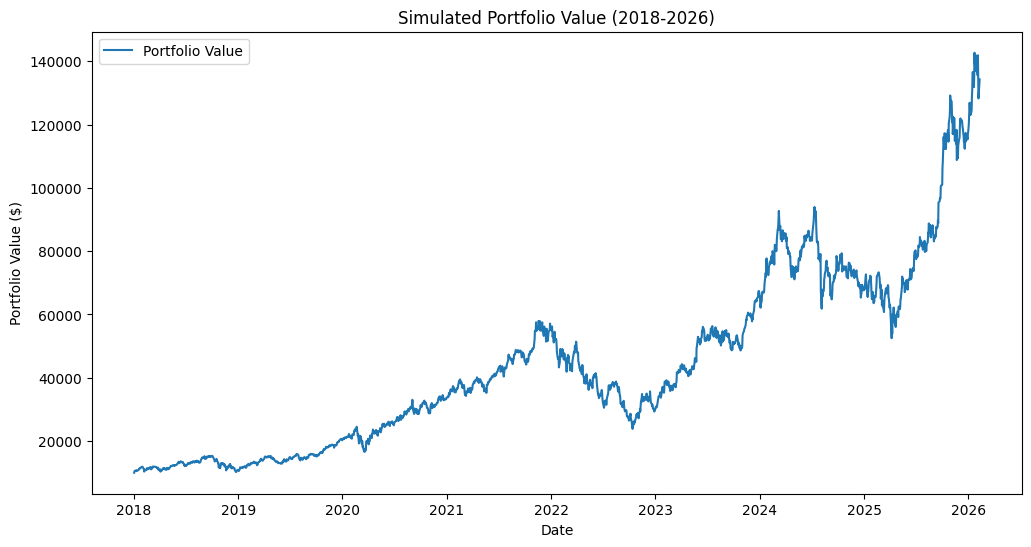

In [47]:
# Initialize portfolio
initial_investment = 10000
weights = {'AMD':0.25, 'ASML':0.25, 'INTC':0.25, 'NVDA':0.25}

# Pivot returns
returns_pivot = data.pivot(index='Date', columns='Ticker', values='Return')

# Portfolio daily returns
returns_pivot.fillna(0, inplace=True)
portfolio_daily_return = (returns_pivot * pd.Series(weights)).sum(axis=1)

# Cumulative portfolio value
portfolio_value = initial_investment * (1 + portfolio_daily_return).cumprod()

# Plot
plt.figure(figsize=(12,6))
plt.plot(portfolio_value, label='Portfolio Value')
plt.title("Simulated Portfolio Value (2018-2026)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()


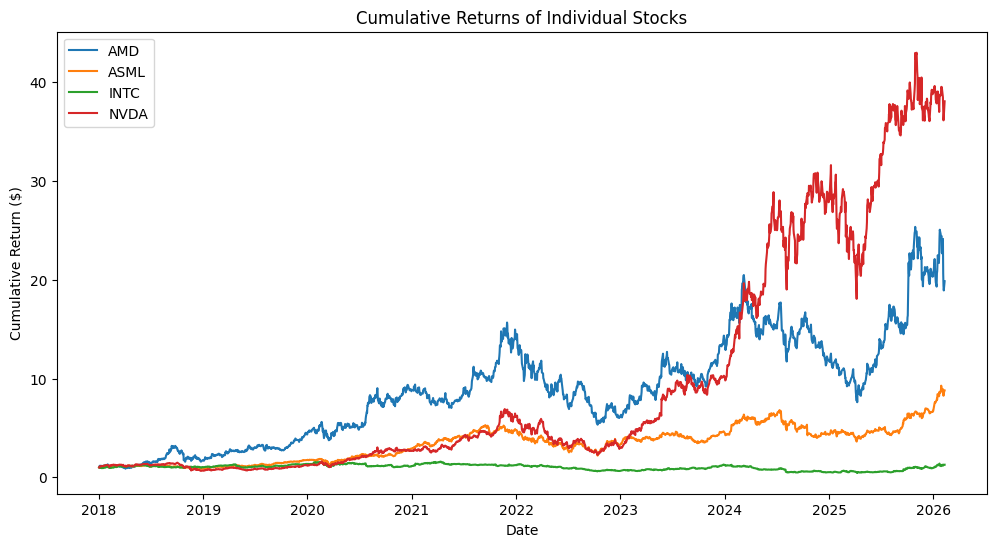

In [48]:
# Individual stock cumulative returns
cumulative_returns = (1 + returns_pivot).cumprod()
plt.figure(figsize=(12,6))
for t in tickers:
    plt.plot(cumulative_returns[t], label=t)
plt.title("Cumulative Returns of Individual Stocks")
plt.xlabel("Date")
plt.ylabel("Cumulative Return ($)")
plt.legend()
plt.show()


In [49]:
# Summary Table of Portfolio Metrics
portfolio_metrics = pd.DataFrame({
    'Total_Return_%': cumulative_returns.iloc[-1]*100/10000 - 100,
    'Volatility': returns_pivot.std()*np.sqrt(252),
    'Sharpe_Ratio': (returns_pivot.mean() / returns_pivot.std()) * np.sqrt(252)
})
portfolio_metrics


,Total_Return_%,Volatility,Sharpe_Ratio
Ticker,,,
AMD,-99.801440,0.569410,0.933623
ASML,-99.912028,0.386823,0.890125
INTC,-99.987264,0.429707,0.285141
NVDA,-99.619319,0.526885,1.118145


# Portfolio Insights
- Investing equally in **all 4 stocks** from 2018-2026:  
  - NVDA gives the **highest return**  
  - ASML is **stable with moderate return**  
  - AMD shows **good momentum**  
  - INTC is **riskier and underperforms**  
- **Recommendation:** Allocate more to NVDA/AMD, ASML for long-term stability, minimize INTC exposure.
